# Cabeçalho

In [1]:
# Thiago Pacheco Carneiro - 2021
# A partir de código de Matheus Klatt:
# https://colab.research.google.com/drive/1ryPL6nAk8OlDw9F5QaYu3GQOqeMEcuZk?usp=sharing#scrollTo=iregsHCQ0hrx

import numpy as np # later try cunumeric as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

from numba import njit


# Modelos

In [2]:
class modelo():
    def __init__(self, Nx = 300, Nz = 300) -> None:
        self.Nx=Nx#300
        self.Nz=Nz#300
        self.vp=np.zeros((self.Nz, self.Nx))
        self.Na=0
        self.Ntopo=0
        self.fat = 0
        self.fat_c = np.ones((self.Nz, self.Nx))
        self.zbv = False
        self.profundidade_zbv = 0
        self.vtopo = 0

    def cria_bordas_cerjan(self,Na = 50,fat=0.0025):
        self.Na += Na
        self.fat = fat

        Nzz = self.Nz + Na
        Nxx = self.Nx + 2*Na
        ext_vp=np.zeros((Nzz,Nxx))
        ext_vp[:-Na,Na:-Na]=self.vp
        for i in range(Na+1):
            ext_vp[-i-1,:]=ext_vp[-Na-1,:]
            ext_vp[:,i]=ext_vp[:,Na+1]
            ext_vp[:,-i-1]=ext_vp[:,-Na-1]
        self.vp=ext_vp
        self.Nz=Nzz
        self.Nx=Nxx
        self.fat_c = np.ones((Nzz,Nxx))
        if Na != 0:
            for i in range(Nzz - Na, Nzz):
                self.fat_c[i, :] = np.exp(-((fat * (Nzz - Na - i)) ** 2))
            for k in range(Na):
                self.fat_c[:, k] = np.exp(-((fat * (Na - k)) ** 2)) * self.fat_c[:, Na]
            for k in range(Nxx - Na+1, Nxx):
                self.fat_c[:, k] = np.exp(-(((fat + 0.5*fat) * (Nxx - Na - k)) ** 2))  * self.fat_c[:, Nxx-Na]
        return self

    def cria_borda_topo(self, Ntopo: int):
        self.Ntopo = Ntopo
        Nzz = self.Nz + self.Ntopo
        ext_vp=np.zeros((Nzz, self.Nx))
        ext_vp[self.Ntopo:,:]=self.vp
        for i in range(self.Ntopo):
            ext_vp[i,:]=self.vp[0,:]
        self.vp = ext_vp
        self.Nz = Nzz
        return self

    def cria_ZBV(self, profundidade = 7, velocidade = 450):
        self.vp[:profundidade,:]=velocidade
        self.zbv = True
        self.profundidade_zbv=profundidade
        return self

    def plot(self):
        plt.imshow(self.vp)

    def plot_fator_cerjan(self):
        plt.imshow(self.fat_c)

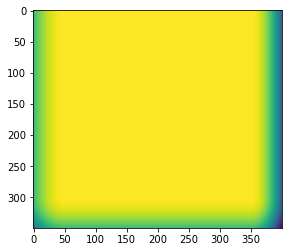

In [3]:
class modelo_homogeneo(modelo):
    def __init__(self, Nx=300, Nz=300, v=1500) -> None:
        super().__init__(Nx=Nx, Nz=Nz)
        self.vp[:,:]=v
        self.vtopo=v

modelo_homogeneo().cria_bordas_cerjan().plot_fator_cerjan()

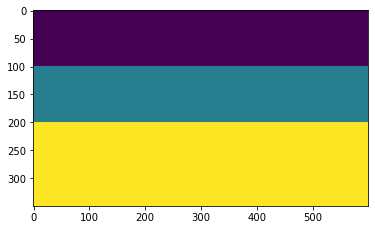

In [4]:
class modelo_paralelas(modelo):
    def __init__(self, Nx = 300, Nz = 300, v = [1500, 3000, 5000]) -> None:
        super().__init__(Nx,Nz)
        self.vp[:int(self.Nz/3),:]=v[0]#1500
        self.vp[int(self.Nz/3):int(2*self.Nz/3),:]=v[1]#3000
        self.vp[int(2*self.Nz/3):,:]=v[2]#5000
        self.vtopo=v[0]

modelo_paralelas(500,300).cria_bordas_cerjan().plot()#_fator_cerjan()

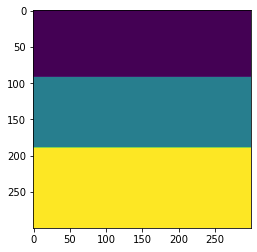

In [5]:
class modelo_parametrizado(modelo):
    def __init__(self, Nx = 300, Nz = 300, zv = ((100,1500), (200,3000), (300,5000))) -> None:
        super().__init__(Nx,Nz)
        início=0
        for fim, velocidade in zv:
            delta_início = 0
#            self.vp[início:,:]=velocidade
            for x in range(self.vp.shape[1]):
                if início != 0:
                    delta_início += np.random.choice([-1,1]+[0]*3)
                self.vp[início + delta_início:,:] = velocidade
            início=fim
        self.vtopo=zv[0][1]

modelo_parametrizado().plot()#_fator_cerjan()

3575
1915
1947
1539
2593
1812
2591
1755
2406
2057
2084
1930
1636
1560
1501


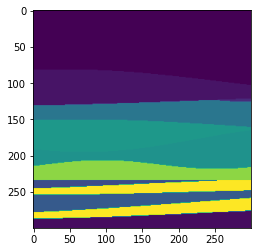

In [6]:
class modelo_randomizado(modelo):
    def __init__(self, Nx=300, Nz=300, n_camadas=15) -> None:
        super().__init__(Nx=Nx, Nz=Nz)
        self.vp[:,:]=1500
        for i in range(n_camadas):
            #d = np.random.randint(-Nz//n_camadas,Nz//n_camadas)
            d = np.random.randint(50,100)
            a = np.random.randint(0,Nz//n_camadas)
            k = 1/np.random.randint(50,Nx)
            fase = np.random.random()*np.pi*2
            velocidade = np.random.randint(1500,1500+2000*(1+n_camadas-i)//n_camadas)
            print(velocidade)
            for x in range(Nx):
                profundidade = int(Nz-i*(Nz//n_camadas)+a*np.sin(k*x+fase))
                self.vp[:profundidade+d,x] = velocidade
        self.vtopo=velocidade
modelo_randomizado().plot()

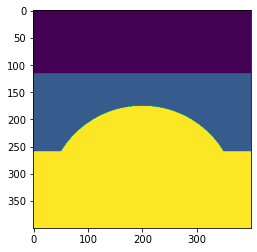

In [7]:
class modelo_circular(modelo):
    def __init__(self,Nx = 300, Nz = 300, v = [1500,2500,5000]) -> None:
        super().__init__(Nx,Nz)
        raio = (self.Nz/2)
        raioq = raio**2
        self.vp[:int(self.Nz/3),:]=v[0]
        for k in range(self.Nx):
            cateto_x = abs(k - (self.Nx/2))
            cateto_z = int(np.sqrt(raioq-cateto_x**2)) if cateto_x<raio else 0
            self.vp[int(self.Nz/3):int(self.Nz-cateto_z),k]=v[1]#3000
            self.vp[int(self.Nz-cateto_z):,k]=v[2]#5000
        self.vtopo = v[0]

modelo_circular(300,350).cria_bordas_cerjan().plot()

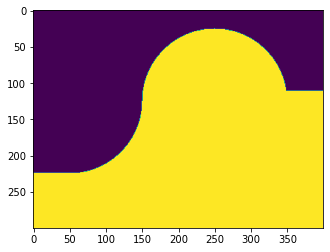

In [8]:
class modelo_dobra(modelo):
    def __init__(self,Nx = 300, Nz = 300, v = [2500,3500]) -> None:
        super().__init__(Nx,Nz)
        raio = self.Nx/3
        raioq = raio**2
        centro = self.Nz/2 if self.Nz/2 >= raio+2 else raio+2
        for k in range(self.Nx):
            if k < raio:
                cateto_x = k
                cateto_z = (np.sqrt(raioq-cateto_x**2)) if cateto_x<=raio else 0
                y = centro + cateto_z
                #y = sqrt((raio_dobra ** 2) - ((k+1)**2)) + 150
            else:
                cateto_x = abs(k - (2*self.Nx/3))
                cateto_z = int(np.sqrt(raioq-cateto_x**2)) if cateto_x<raio else 0
                y = centro - cateto_z
                #y = -sqrt((raio ** 2) - (((k+1) - 200) ** 2)) + 150
            self.vp[:int(y),k]=v[0]
            self.vp[int(y):,k]=v[1]
        self.vtopo = v[0]
modelo_dobra(300,250).cria_bordas_cerjan().plot()

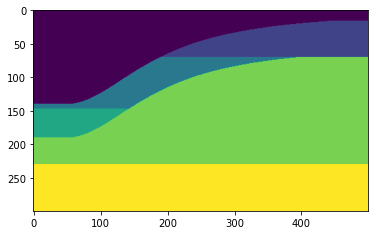

In [9]:
class modelo_reservatorio(modelo):
    def __init__(self,Nx = 300, Nz = 300, v = [1500,2000,2500,3000,3500,4000]) -> None:
        super().__init__(Nx,Nz)
        me = 70
        for k in range(self.Nx):
            for i in range(self.Nz):
                y = ((8 * me ** 3) / ((k+1) ** 2 + 4 * me ** 2))

                if i <= y:
                    self.vp[i,k] = v[0]#1500
                elif i < 70:
                    self.vp[i,k] = v[1]#2000
                elif i >= 70 and i < (y + 50) and i < 147:
                    self.vp[i,k] = v[2]#2500
                elif i >= 147 and i < (y + 50):
                    self.vp[i,k] = v[3]#3000
                elif i >= (y + 50) and i < 230:
                    self.vp[i,k] = v[4]#3500
                else:
                    self.vp[i,k] = v[5]#4000
        self.vtopo = v[0]

modelo_reservatorio(400,250).cria_bordas_cerjan().plot()

[2330. 2590. 3180. 3750. 4070. 4450.]


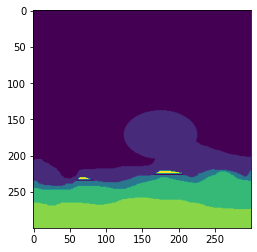

In [10]:
class modelo_bitmap(modelo):
    def __init__(self, Nx=300, Nz=300, arquivo="modelo.png") -> None:
        super().__init__(Nx=Nx, Nz=Nz)
        bitmap = PIL.Image.open(arquivo).convert('L')
        self.vp=10.*np.array(bitmap)+2000
        self.vtopo = self.vp[0,0]
print(np.unique(modelo_bitmap(arquivo="modelo-simp.png").vp))
modelo_bitmap(arquivo="modelo-simp.png").plot()

# Fonte

393 5.641895835477563 0.11816359006036772


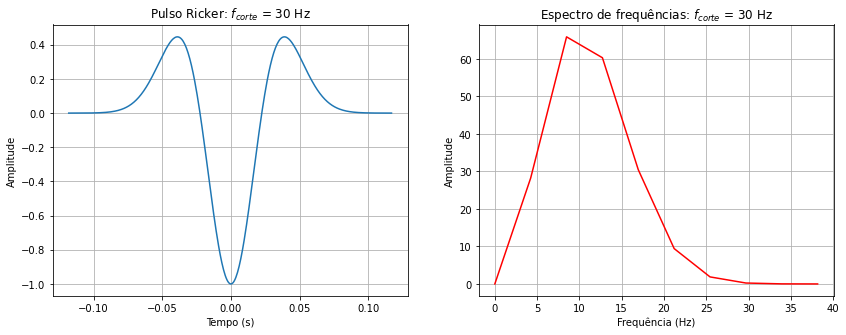

In [11]:
class fonte_sismica():
    def __init__(self,fcorte = 30, Nt0 = 0, dt = 0.0006, x = 150, z = 5, intensidade = 1.) -> None:
        self.fcorte = fcorte #30     # frequência de corte (Hz)
        self.Nt0 = Nt0
        self.dt = dt #0.0006
        self.x = x
        self.z = z

        self.Nf = int(4 * np.sqrt(np.pi) / (self.fcorte * self.dt)) # Passos de tempo ao longo dos quais a fonte é injetada (tm discretizado)

        self.pulso = np.zeros(self.Nf) # Inicialização do vetor que guarda o as amplitudes do pulso Ricker que é usado como fonte
        self.t = np.zeros(self.Nf) # Inicialização do vetor (td) que guarda os instantes de tempo em segundos nos quais a fonte é aplicada

        self.TF = 2 * np.sqrt(np.pi) / self.fcorte       # Período da função Gaussiana (t0)
        self.fc = self.fcorte / (3. * np.sqrt(np.pi))    # Frequência central

        # Laço que cria o pulso Ricker para cada instante (td) de aplicação da fonte
        for n in range(self.Nf):
            self.t[n] = n*self.dt - self.TF + self.Nt0*self.dt
            self.pulso[n] = intensidade*(-np.exp(-np.pi * (np.pi * self.fc * self.t[n]) ** 2) * (1 - 2 * np.pi * (np.pi * self.fc * self.t[n]) * (np.pi * self.fc * self.t[n])))
    
    def plot(self):
        print(self.Nf,self.fc,self.TF)


        fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
        #f_=np.linspace(0,2*self.fcorte,100) # vetor que guarda as frequencias para calculo da transformada da fonte
        #fonte_f = 2*f_**2/(np.pi**2*self.fc**3)*np.exp((-(f_**2)/(np.pi*self.fc**2))) # calculo da transformada de Fourier do pulso Ricker, para as frequencias do vetor 'f_'
        fonte_f = np.abs(np.fft.rfft(self.pulso))
        freq = np.fft.fftfreq(len(self.pulso),self.dt)

        ax0.set_title("Pulso Ricker: " + r'$f_{corte}$' + " = {} Hz".format(self.fcorte))
        #ax0.plot(self.t+self.TF, self.pulso) # Plot do pulso Ricker a partir do tempo 0.0s até tm
        ax0.plot(self.t,self.pulso) # Plot do pulso Ricker a partir do tempo 0.0s até tm
        ax0.set_xlabel("Tempo (s)")
        ax0.set_ylabel("Amplitude")
        ax1.set_title("Espectro de frequências: " + r'$f_{corte}$' + " = {} Hz".format(self.fcorte)) 
        ax1.plot(freq[:10],fonte_f[:10],c="red") # Plot do espectro de frequencias do pulso Ricker para as frequencias contidas no vetor 'f_'
        ax1.set_xlabel("Frequência (Hz)")
        ax1.set_ylabel("Amplitude")
        ax0.grid()
        ax1.grid()

fonte_sismica().plot()       

# Malha

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


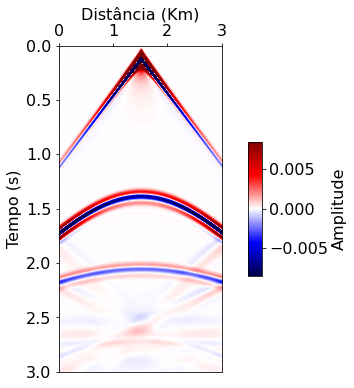

In [12]:
class malha():
    def __init__(self, modelo, fonte=fonte_sismica(), cerjan = False, reynolds = False, suprime_ruido = False, z_receptor=5, Na=50) -> None:
        self.mod = modelo
        self.fontes = [fonte]
        self.cerjan=cerjan
        self.reynolds=reynolds
        self.suprime_ruido = suprime_ruido

        if self.suprime_ruido:
            self.mod.cria_borda_topo(self.mod.Nz)
            
        if self.cerjan:
            self.mod.cria_bordas_cerjan(Na=Na)
        
        self.dt = 0.0006

        self.h = 10

        self.A = self.mod.vp * (self.dt/self.h)
        self.C = - (self.A**2)/12
        
        self.z_receptor = z_receptor+self.mod.Ntopo
        self.ntotal = 5000

        self.P1 = np.zeros((self.mod.Nz, self.mod.Nx))               # Matriz no tempo passado
        self.P2 = np.zeros((self.mod.Nz, self.mod.Nx))               # Matriz no tempo presente
        self.P3 = np.zeros((self.mod.Nz, self.mod.Nx))               # Matriz no tempo futuro
        self.sis = np.zeros((self.ntotal, self.mod.Nx-(2*self.mod.Na)))          # Matriz do sismograma

        self.nsnaps = 20
        self.snaps_t = np.linspace(0,self.ntotal-1,self.nsnaps,dtype=np.int32)
        self.P_snaps=np.zeros((self.nsnaps,self.mod.Nz,self.mod.Nx))

    def insere_fonte(self, Nt0 = 0, x = 150, z=5, intensidade = 1):
        self.fontes.append(fonte_sismica(Nt0 = Nt0, dt = self.dt, x = x, z = z, intensidade = intensidade))
    
    @njit(parallel=True)
    def executa_mdf(C,P1,P2,P3):
        P3[2:-2, 2:-2] = \
            C[2:-2,2:-2] * ( \
                P2[2:-2, 4:] + P2[2:-2, :-4] + P2[4:, 2:-2] + P2[:-4, 2:-2] \
                - 16 * (P2[2:-2, 3:-1] + P2[2:-2, 1:-3] + P2[3:-1, 2:-2] + P2[1:-3, 2:-2]) \
                + 60 * (P2[2:-2, 2:-2]) \
            ) + 2 * (P2[2:-2, 2:-2]) - P1[2:-2, 2:-2]
    
    @njit(parallel=True)
    def calcula_reynolds(A,P2,P3):
        P3[:2,2:-2] = P2[:2,2:-2] + A[:2,2:-2] * (P2[1:3, 2:-2] - P2[:2,2:-2])
        P3[-2:,2:-2] = P2[-2:,2:-2] - A[-2:,2:-2] * (P2[-2:, 2:-2] - P2[-3:-1,2:-2])
        P3[2:-2,:2] = P2[2:-2,:2] + A[2:-2,:2] * (P2[2:-2, 1:3] - P2[2:-2,:2])
        P3[2:-2,-2:] = P2[2:-2,-2:] - A[2:-2,-2:] * (P2[2:-2, -2:] - P2[2:-2,-3:-1])
    
    @njit(parallel=True)
    def calcula_cerjan(P2,P3,fat_c):
        P2 *= fat_c
        P3 *= fat_c        
                
    def modelagem(self, z_receptor=False):
        if z_receptor:
            self.z_receptor = z_receptor + self.mod.Ntopo
        c_snap=0
        for n in range(self.ntotal):
            for fnt in self.fontes:
                if fnt.Nt0 <= n < fnt.Nt0+fnt.Nf:
                    z = fnt.z + self.mod.Ntopo
                    x = fnt.x + self.mod.Na
                    v = self.A[z, x]
                    self.P2[z, x] += fnt.pulso[n-fnt.Nt0] * v * v
            malha.executa_mdf(self.C,self.P1,self.P2, self.P3)
            if self.reynolds:
                malha.calcula_reynolds(self.A,self.P2,self.P3)
            if self.cerjan:
                malha.calcula_cerjan(self.P2, self.P3, self.mod.fat_c)
            self.P1 = self.P2
            self.P2 = self.P3
            self.P3 = self.P3.copy()
            self.sis[n,:] = self.P3[self.z_receptor,self.mod.Na:self.mod.Nx-self.mod.Na]
            if(n == self.snaps_t[c_snap]):
                self.P_snaps[c_snap] = self.P3
                c_snap+=1
        return self


    def plot(self, remover_onda_direta=False, reescalonar=False):
        if (remover_onda_direta):
            modelo_h=modelo_homogeneo(self.mod.Nx-(2*self.mod.Na),self.mod.Nz-self.mod.Na-self.mod.Ntopo,self.mod.vtopo)
            if self.mod.profundidade_zbv > 0:
                modelo_h.cria_ZBV(profundidade=self.mod.profundidade_zbv)
            if self.mod.Ntopo > 0:
                modelo_h.cria_borda_topo(self.mod.Nx)
            sis_homogeneo=malha(modelo_h,fonte_sismica(),self.cerjan, self.reynolds,z_receptor=self.z_receptor-self.mod.Ntopo).modelagem().sis
            sis_eff=self.sis-sis_homogeneo
        else:
            sis_eff=self.sis

        ## Eixos em dimensões reais
        scaleX = 1.0 / 1000
        scaleZ = 1

        Xmin = (0 * self.h) * scaleX
        Xmax = ((self.mod.Nx-(2*self.mod.Na)) * self.h) * scaleX
        Zmin = (0 * self.dt) * scaleZ
        Zmax = (self.ntotal * self.dt) * scaleZ

        ## Eixo horizontal no topo da figura
        plt.rcParams['xtick.bottom'] = False
        plt.rcParams['xtick.labelbottom'] = False
        plt.rcParams['xtick.top'] = True
        plt.rcParams['xtick.labeltop'] = True

        plt.rc('xtick', labelsize=16)   
        plt.rc('ytick', labelsize=16)
        plt.rcParams.update({'font.size':16})

        if reescalonar:
            max_sis = np.max(np.abs(sis_eff))
        else:
            max_sis = np.max(np.abs(self.sis))
        
        ## Formatação do plot
        fig, ax = plt.subplots(figsize=(6,6))
        ax.xaxis.set_label_position('top')
        im = ax.imshow(sis_eff, cmap='seismic', vmin=-max_sis*50**(-1), vmax=max_sis*50**(-1), extent=[Xmin,Xmax,Zmax,Zmin], interpolation='bicubic', aspect=2)
        cbar = fig.colorbar(im, ax=ax, fraction=0.04, pad=0.08, label='Amplitude', aspect=10)
        plt.xlabel('Distância (Km)', fontsize=16)
        plt.ylabel('Tempo (s)', fontsize=16)
        plt.show()


    def plot_snaps(self, n_plots=6):
         ## Eixos em dimensões reais
        scaleX = 1.0 / 1000
        scaleZ = 1.0 / 1000

        Xmax = (self.mod.Nx * self.h - 2*self.mod.Na*self.h) * scaleX
        Zmax = (self.mod.Nz * self.h - self.mod.Na*self.h) * scaleZ

        # Definição dos snapshots/instantes de propagação/cortes que serão exibidos na imagem.
        # Todos os snapshots estão contidos na matriz 3D P_snaps[nsnaps,Nzz,Nxx]
        plot_snaps=np.arange(1,self.nsnaps,2) # vetor para seleção apenas dos índices ímpares do número total e snapshots, nsnaps
        plot_snaps=plot_snaps[:n_plots] # seleção dos 6 primeiros elementos do vetor de índices ímpares criado anteriormente
        snaps_t=self.snaps_t[plot_snaps] # seleção instantes de propagação que serão exibidos na imagem, de acordo com os 6 índices selecionados
        snap_time = np.round(snaps_t*self.dt,2) # conversão do instantes de propagação da escala discreta em passos de tempo para escala contínua em segundos

        # Definição da amplitude máxima (e mínima) que será usada como referência para a escala de amplitudes da imagem
        # A amplitude máxima é obtidda a partir do máximo detectado nas snapshots registradas da modelagem SEM tratamento nas bordas
        # estas snapshots estão contidas no argumento P_snaps_ref[nsnaps,Nzz,Nxx] que também é passado para (R11)
        max_snap = np.max(np.abs(self.P_snaps)) 

        plt.rcParams['xtick.bottom'] = True
        plt.rcParams['xtick.labelbottom'] = True
        plt.rcParams['xtick.top'] = False
        plt.rcParams['xtick.labeltop'] = False

        plt.rc('xtick', labelsize=12)   
        plt.rc('ytick', labelsize=12)
        plt.rcParams.update({'font.size':12})   

        ## Formatação do gráfico
        fig, ax = plt.subplots(nrows=1,ncols=n_plots,figsize=(18,4),sharey=True)
        ax[0].set_ylabel('Profundidade (Km)', fontsize=13)
        ax[0].set_yticks([0,int((self.mod.Nz-self.mod.Na)/2)-1,(self.mod.Nz-self.mod.Na)-1])
        ax[0].set_yticklabels(np.round(np.linspace(0,(Zmax),num=3),1))  

        # Título geral da imagem
        fig.suptitle('Snapshots da propagação', fontsize=14)

        for i in range(len(ax)):
            im=ax[i].imshow(self.P_snaps[plot_snaps[i],:self.mod.Nz-self.mod.Na,self.mod.Na:self.mod.Nx-self.mod.Na], cmap='seismic', vmin=-max_snap*10**(-1), vmax=max_snap*10**(-1),aspect=1.5)
            ax[i].imshow(self.mod.vp[:self.mod.Nz-self.mod.Na,self.mod.Na:self.mod.Nx-self.mod.Na],aspect=1.5,alpha=0.5)
            ax[i].set_title("t = {} s".format(snap_time[i]))
            ax[i].set_xlabel('Distância (Km)', fontsize=13)
            ax[i].set_xticks([0,int((self.mod.Nx-2*self.mod.Na)/2),self.mod.Nx-2*self.mod.Na])
            ax[i].set_xticklabels(np.round(np.linspace(0,(Xmax),num=3),1))

        # Configuração da barra de cores que representa as faixa de valores das amplitudes do campo de onda
        fig.subplots_adjust(right=0.7125)
        cbar_ax = fig.add_axes([0.825, 0.35, 0.1, 0.35])
        cbar_ax.set_yticks([])
        cbar_ax.set_xticks([])
        cbar_ax.axis("off")
        cbar = fig.colorbar(im, ax=cbar_ax, fraction=2, pad=0.005, label='Amplitude')   

        plt.show()
malha(modelo_paralelas(),cerjan=True,reynolds=True).modelagem().plot(remover_onda_direta=False)
#malha(modelo_paralelas(),fonte_sismica(),cerjan=True,reynolds=True).modelagem().plot_snaps(7)

# Testes

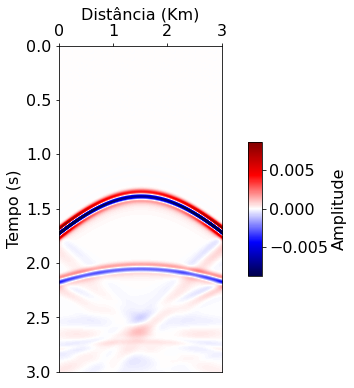

In [13]:
malha(modelo_paralelas(),cerjan=True,reynolds=True,suprime_ruido=True).modelagem().plot(remover_onda_direta=True)

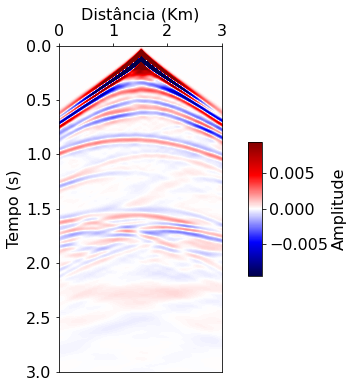

In [14]:
malha(modelo_bitmap(arquivo="modelo.png"),cerjan=True,reynolds=True).modelagem().plot()

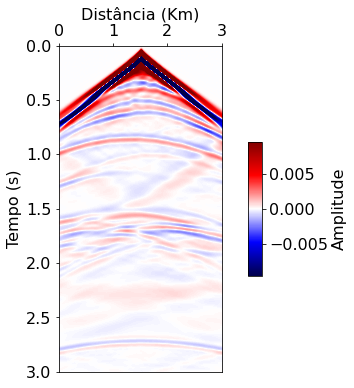

In [15]:
malha(modelo_bitmap(arquivo="modelo.png"),cerjan=True,reynolds=True,suprime_ruido=True).modelagem().plot()

# Teste das 4 combinações {Cerjan,Reynolds}

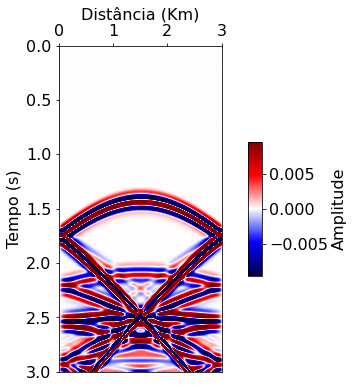

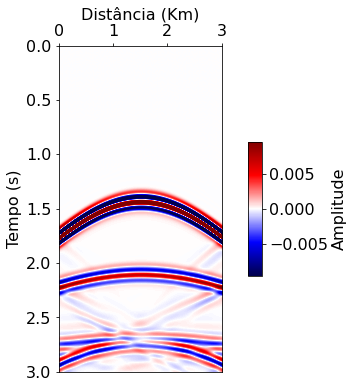

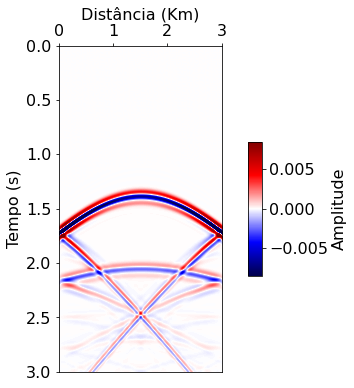

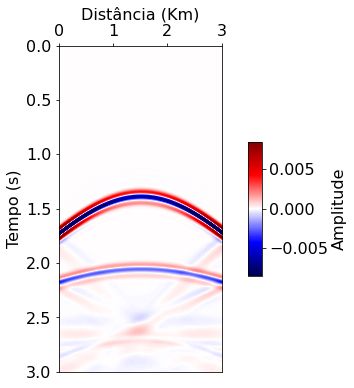

In [16]:
malha(modelo_paralelas(),fonte_sismica(),cerjan=False,reynolds=False).modelagem().plot(remover_onda_direta=True)
malha(modelo_paralelas(),fonte_sismica(),cerjan=True,reynolds=False).modelagem().plot(remover_onda_direta=True)
malha(modelo_paralelas(),fonte_sismica(),cerjan=False,reynolds=True).modelagem().plot(remover_onda_direta=True)
malha(modelo_paralelas(),fonte_sismica(),cerjan=True,reynolds=True).modelagem().plot(remover_onda_direta=True)

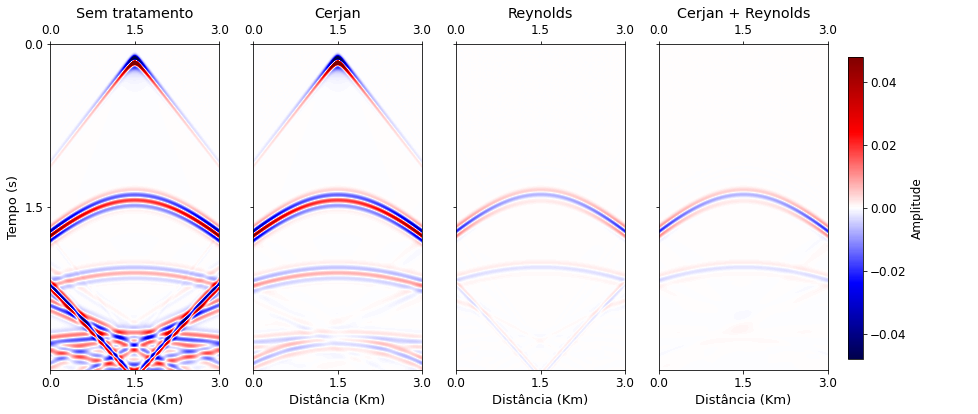

()

In [17]:
# Rotina (R10) para visualização comparativa dos sismogramas gerados por modelagem com cada uma das 
# 4 possíveis configurações de borda: sem atenuação, apenas atenuação Cerjan, apenas atenuação Reynolds, e ambos os tipos
# de atenuação.
def comp_sis():#sis_00,sis_01,sis_02,sis_03,sis_homogeneo,h,dt,Nx,Nz,ntotal):
  sis_00=malha(modelo_paralelas().cria_bordas_cerjan(),fonte_sismica(),cerjan=False,reynolds=False).modelagem().sis
  sis_01=malha(modelo_paralelas(),fonte_sismica(),cerjan=True,reynolds=False).modelagem().sis
  sis_02=malha(modelo_paralelas().cria_bordas_cerjan(),fonte_sismica(),cerjan=False,reynolds=True).modelagem().sis
  sis_03=malha(modelo_paralelas(),fonte_sismica(),cerjan=True,reynolds=True).modelagem().sis
  sis_homogeneo=malha(modelo_homogeneo(),fonte_sismica(),cerjan=True,reynolds=True).modelagem().sis

  h = 10
  dt = 0.0006
  Nx=300
  Nz=300
  ntotal = 5000

  ## Eixos em dimensões reais
  scaleX = 1.0 / 1000
  scaleZ = 1

  Xmin = (0 * h) * scaleX
  Xmax = (Nx * h) * scaleX
  Zmin = (0 * dt) * scaleZ
  Zmax = (ntotal * dt) * scaleZ


  ## Eixo horizontal na parte inferior da figura
  plt.rcParams['xtick.bottom'] = True
  plt.rcParams['xtick.labelbottom'] = True

  # Tamanho da fonte do texto das legendas
  plt.rc('xtick', labelsize=12)   
  plt.rc('ytick', labelsize=12)
  plt.rcParams.update({'font.size':12})

  # Definição do máximo (e mínimo) usado na escala dos 4 diferentes sismogramas, que tem como referência a maior amplitude
  # do sismograma gerado pela modelagem sem tratamento nas bordas
  max_sis = np.max(np.abs(sis_00))

  ## Formatação do gráfico
  fig, (ax0,ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=4,figsize=(16,6),sharey=True)
  ax0.set_ylabel('Tempo (s)', fontsize=13)
  ax0.set_yticks([0,int(ntotal/2),ntotal])
  ax0.set_yticklabels(np.round(np.linspace(0,(Zmax),num=3),1))

  # Exibição do primeiro sismograma
  ax0.imshow(np.add(sis_00,-sis_homogeneo), cmap='seismic', vmin=-max_sis*10**(-1), vmax=max_sis*10**(-1),aspect = "auto")
  
  # Exibição do segundo sismograma
  ax1.imshow(np.add(sis_01,-sis_homogeneo), cmap='seismic', vmin=-max_sis*10**(-1), vmax=max_sis*10**(-1),aspect = "auto")
  
  # Exibição do terceiro sismograma
  ax2.imshow(np.add(sis_02,-sis_homogeneo), cmap='seismic', vmin=-max_sis*10**(-1), vmax=max_sis*10**(-1),aspect = "auto")
  
  # Exibição do quarto sismograma
  im = ax3.imshow(np.add(sis_03,-sis_homogeneo), cmap='seismic', vmin=-max_sis*10**(-1), vmax=max_sis*10**(-1),aspect = "auto")
  
  # Configuração da barra de cores comum a todos os sismogramas
  fig.subplots_adjust(right=0.8)
  cbar_ax = fig.add_axes([0.925, 0.15, 0.0025, 0.7])
  cbar_ax.set_yticks([])
  cbar_ax.set_xticks([])
  cbar_ax.axis("off")
  cbar = fig.colorbar(im, ax=cbar_ax, fraction=44, pad=0.01, label='Amplitude')
  
  # Legendas do primeiro sismograma
  ax0.set_title("Sem tratamento")
  ax0.set_xlabel('Distância (Km)', fontsize=13)
  ax0.set_xticks([0,int(Nx/2),Nx])
  ax0.set_xticklabels(np.round(np.linspace(0,(Xmax),num=3),1))

  # Legendas do segundo sismograma
  ax1.set_title("Cerjan")
  ax1.set_xlabel('Distância (Km)', fontsize=13)
  ax1.set_xticks([0,int(Nx/2),Nx])
  ax1.set_xticklabels(np.round(np.linspace(0,(Xmax),num=3),1))

  # Legendas do terceiro sismograma
  ax2.set_title("Reynolds")
  ax2.set_xlabel('Distância (Km)', fontsize=13)
  ax2.set_xticks([0,int(Nx/2),Nx])
  ax2.set_xticklabels(np.round(np.linspace(0,(Xmax),num=3),1))

  # Legendas do quarto sismograma
  ax3.set_title("Cerjan + Reynolds")
  ax3.set_xlabel('Distância (Km)', fontsize=13)
  ax3.set_xticks([0,int(Nx/2),Nx])
  ax3.set_xticklabels(np.round(np.linspace(0,(Xmax),num=3),1))  

  plt.show()   

  return()
comp_sis()

# Propagação da onda sísmica

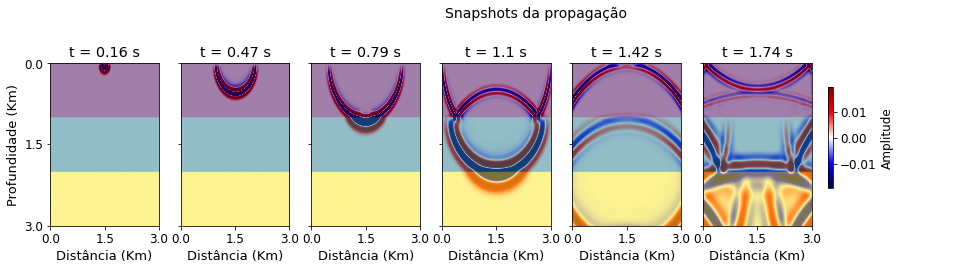

In [18]:
malha(modelo_paralelas().cria_bordas_cerjan(),fonte_sismica(),cerjan=False,reynolds=False).modelagem().plot_snaps()

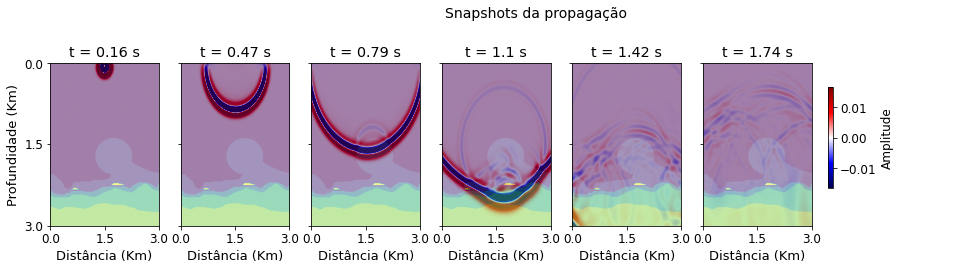

In [19]:
malha(modelo_bitmap(arquivo="modelo-simp.png").cria_bordas_cerjan(),fonte_sismica(),cerjan=True,reynolds=True).modelagem().plot_snaps()

# Simula ZBV

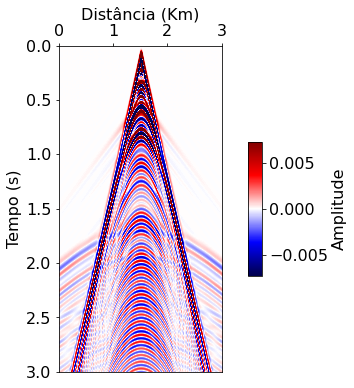

In [20]:
def simula_ZBV(modelo=modelo_paralelas(), profundidade = 15, velocidade = 450):
    modelo.cria_ZBV(profundidade=profundidade, velocidade=velocidade)
    m = malha(modelo,cerjan=True,reynolds=True)
    m.modelagem()
    m.plot()
    #m.plot_snaps()
simula_ZBV()

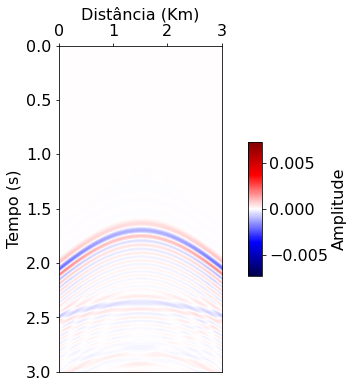

In [21]:
def simula_ZBV_suprimida(modelo=modelo_paralelas(), profundidade = 15, velocidade = 450):
    modelo.cria_ZBV(profundidade=profundidade, velocidade=velocidade)
    m = malha(modelo,cerjan=True,reynolds=True,suprime_ruido=True)
    m.modelagem()
    m.plot(remover_onda_direta=True)
    #m.plot_snaps()
simula_ZBV_suprimida()

# Testes ZBV

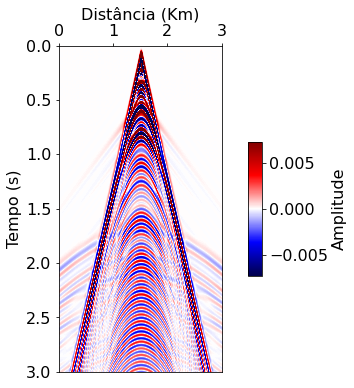

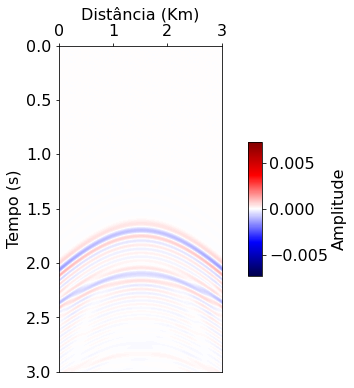

In [22]:
simula_ZBV(modelo_circular())
simula_ZBV_suprimida(modelo_circular())

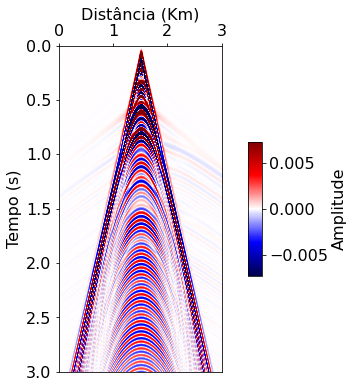

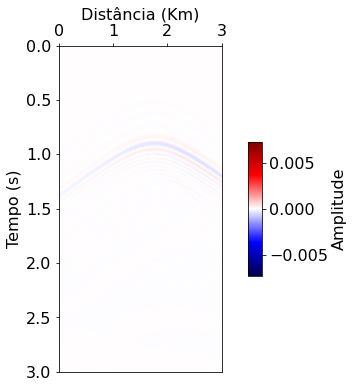

In [23]:
simula_ZBV(modelo_dobra())
simula_ZBV_suprimida(modelo_dobra())

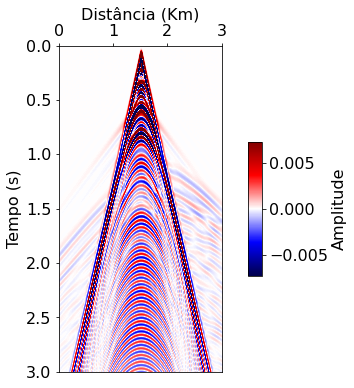

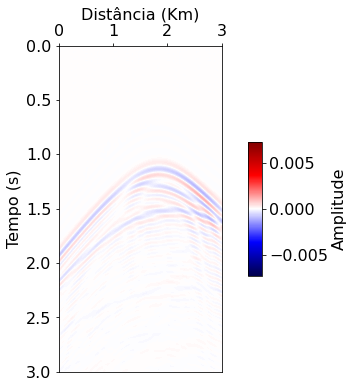

In [24]:
simula_ZBV(modelo_reservatorio())
simula_ZBV_suprimida(modelo_reservatorio())

# Gera modelos aleatórios

2
 


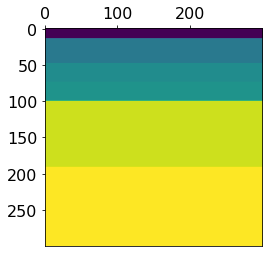

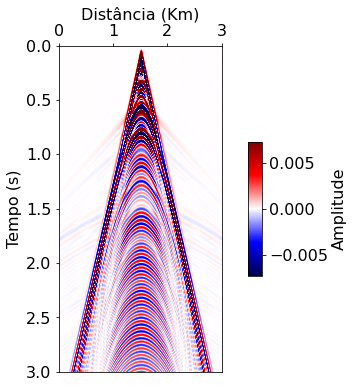

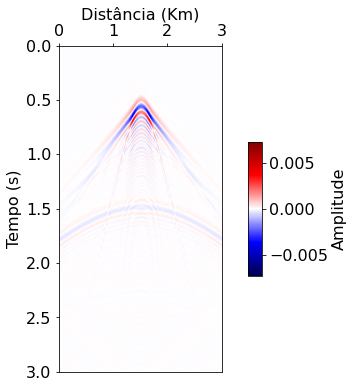

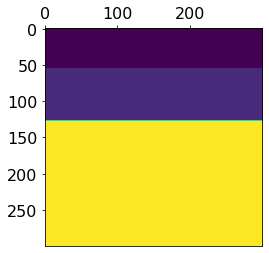

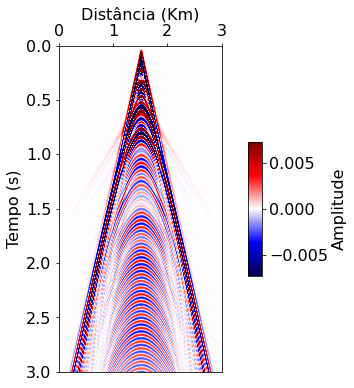

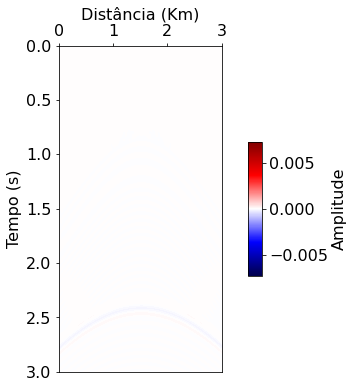

In [25]:
def gera_modelos():
    comprimento_total = 300
    trecho_mínimo = 10
    modelos = []
    for idx_modelo in range(2):
        início = 0
        zv = []
        finalizado = False
        velocidade = np.random.randint(800,1000)
        n_camadas = np.random.randint(3,7)
        for camada in range(n_camadas):
            if finalizado:
                break
            head = int(início+trecho_mínimo)
            toe = int(início + trecho_mínimo + (comprimento_total - início) / ((n_camadas-camada)))
            fim = np.random.randint( head, toe)
            if fim >= comprimento_total - trecho_mínimo:
                fim = comprimento_total
                finalizado = True
            velocidade = np.random.randint(velocidade, velocidade + 500)
            zv.append((fim,velocidade))
            início = fim
        modelo_n = modelo_parametrizado(Nz=comprimento_total,zv=zv)
        modelos.append(modelo_n)
    return modelos

print(len(gera_modelos()))

for modelo_n in gera_modelos():
    print(" ")
    modelo_n.plot()
    simula_ZBV(modelo=modelo_n)
    simula_ZBV_suprimida(modelo=modelo_n)

# Gera ondulado

 
2615
1556
2261
1514
2035
1547
2424
2521
2444
2402
1581
1654
1927
1701
1707


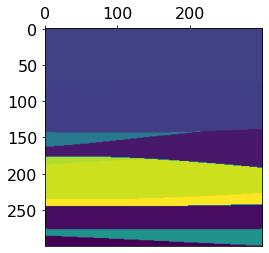

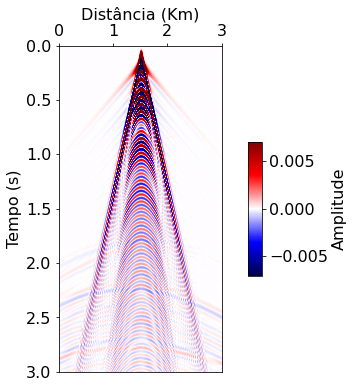

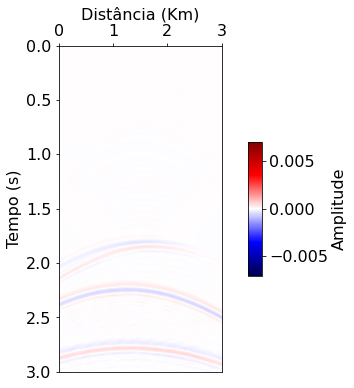

 
2270
3014
1626
2627
3078
2292
1986
1682
1743
1556
1918
1742
1629
1591
1601


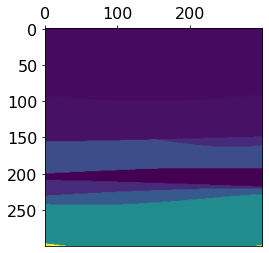

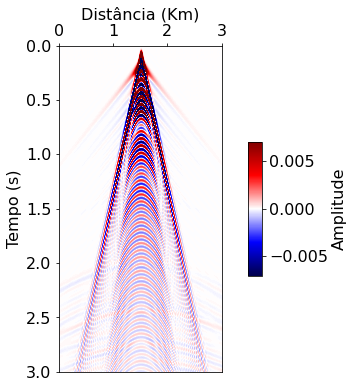

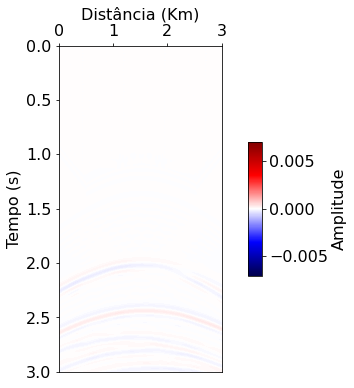

In [26]:
for n in range(2):
    print(" ")
    modelo = modelo_randomizado()
    modelo.plot()
    simula_ZBV(modelo=modelo, profundidade=7)
    simula_ZBV_suprimida(modelo=modelo, profundidade=7)

# Fim

In [27]:
print('testes ok!')

testes ok!
